# POLI 381 Data Project 1: Description

## Are elections becoming more competitive or less competitive?

1. Description: Conceptualize and measure electoral competitiveness. Find a data set that contains your measure of electoral competitiveness or the information necessary to construct that measure. Describe that measure using statistical and graphical methods. This involves noting the scope and coverage of your measure. For example, do you limit your sample to certain jurisdictions, time periods or electoral systems?

2. Correlation: Correlate your measure of electoral competitiveness with electoral turnout. Is turnout higher at more competitive elections?

--- 

Are elections becoming more competitive or less competitive?

For the first part of the project, I will conceptualize and measure electoral competitiveness. To do this, I will use polling data sourced from 538, a website for opinion poll analysis, politics, economics, and sports in the US. This data set logs the daily polling averages for every Presidential candidate between 1968 and 2016. It shows each candidate's daily polling average in every state leading up to the election date. 

In this project, electoral competitiveness will be conceptualized as a comparison of Presidential candidates' polling averages. A competitive election can therefore be conceived as one where the average rating of the top two Presidential candidates are relatively close, given that there are at least two candidates.  

Here are some examples of competitive and non-competitive elections under these definitions:
-  Competitive election: Candidate A has a rating of 32%, candidate B has a rating of 48%, and the remaining 20% is split among several other candidates.
-  Competitive election: Three candidates have an approximately equal rating. 
-  Non-Competitive election: Candidate A has a rating of 90%, candidate B has a rating of 10%.
- Non-Competitive election: There is only one candidate.
    
    Electoral competitiveness will be measured using the 538 data set. For each election:
1. Only data from April 9th onward will be considered, so that each election's data covers an approximately equivalent time frame. This is to ensure a fair comparison. 
2. The states will be put into 9 groups, based on the Census Regions and Divisions of the United States (https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf). This is to simplify analysis. 
3. Each candidate's polling average from April 9th to election day per division will be calculated.
4. Each candidate's national polling average will be computed by taking a weighted average based on the number of electoral votes each division gets (https://www.britannica.com/story/how-many-electoral-college-votes-does-each-us-state-have).
5. A comparison of candidates' national polling average will provide information about the election's competitiveness. 

---

Link to the original data in .csv format: https://github.com/fivethirtyeight/data/blob/76c471a9124d690ba92709ca21cbfcdde226b44e/polls/pres_pollaverages_1968-2016.csv

Link to the tidied data in .csv format:


R code for reading in, tidying and performing statistical analyses on the data:



Stata code for generating graphics:

<br><br>

In [29]:
#imports

library(lubridate)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(dplyr)
library(data.table)

In [30]:
# LOADING AND TIDYING DATA 

# load in data from .csv
data_raw <- read.csv("data/pres_poll_avgs_1968-2016.csv")

# only keep relevant columns 
data_tidy <- select(data_raw, cycle:pct_estimate,election_date)
 
# rename modeldate column
data_tidy <- rename(data_tidy, model_date = modeldate)
data_tidy <- rename(data_tidy, election_year = cycle)

# change model_date and election_date from char to date format for easier manipulation 
data_tidy$election_date <- mdy(data_tidy$election_date)
data_tidy$model_date <- mdy(data_tidy$model_date)  

# head(data_tidy)

# Extract month and day from date column  
data_tidy$month <- month(data_tidy$model_date)
data_tidy$day <- day(data_tidy$model_date)

# Filter out rows where the date is before April 9th
filtered_data_out <- data_tidy |>
  filter(month > 3 & day > 8)

# filtered_data

# show the earliest date with data recorded for each election to ensure the right subset of data was taken
first_dates_by_election_year <- filtered_data_out |>
  group_by(election_year) |>
  slice_head(n = 1) |>
  select(election_year, model_date)

# first_dates_by_election_year

# creating a .csv file for the filtered_data
write.csv(filtered_data_out, "data/filtered_data.csv", row.names = FALSE)

In [31]:
# GROUPING THE DATA AND REMOVING UNNEEDED COLUMNS

all_years <- read.csv("data/filtered_data.csv")
# head(all_years)

# Grouping states by division 
grouped_by_division <- all_years |>
    filter(!(state %in% c("ME-1", "ME-2", "NE-1", "NE-2", "NE-3", "National"))) |>
  mutate(division = case_when(
    state %in% c("Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont") ~ "New England",
    state %in% c("New Jersey", "New York", "Pennsylvania") ~ "Middle Atlantic",
    state %in% c("Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin") ~ "East North Central",
    state %in% c("Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota") ~ "West North Central",
    state %in% c("Delaware", "District of Columbia", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "West Virginia") ~ "South Atlantic",
    state %in% c("Alabama", "Kentucky", "Mississippi", "Tennessee") ~ "East South Central",
    state %in% c("Arkansas", "Louisiana", "Oklahoma", "Texas") ~ "West South Central",
    state %in% c("Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming") ~ "Mountain",
    state %in% c("Alaska", "California", "Hawaii", "Oregon", "Washington") ~ "Pacific"
  ))

# remove any unneeded columns 
grouped_by_division <- grouped_by_division |>
                select(election_year, candidate_name, pct_estimate, division,model_date) 

# grouped_by_district

In [32]:
# CALCULATING PER DISTRICT POLLING AVERAGE FOR EACH CANDIDATE IN EACH ELECTION

# Define the function to calculate averages by year (unchanged)
calculate_average_by_year <- function(dataframe, year) {
  filtered_data <- filter(dataframe, election_year == year)
  average_pct_estimates <- aggregate(
    pct_estimate ~ candidate_name + division,
    data = filtered_data,
    FUN = mean
  )
  average_pct_estimates$election_year <- year  # Add year information
  return(average_pct_estimates)
}

# Create an empty dataframe to store combined results
all_year_averages <- data.frame()  # Start with an empty dataframe

# Iterate through years and append results to the dataframe
years <- c(2016, 2012, 2008, 2004, 2000, 1996, 1992, 1988, 1984, 1980, 1976, 1972)
for (year in years) {
  year_df <- calculate_average_by_year(grouped_by_division, year)
  all_year_averages <- rbind(all_year_averages, year_df)  # Append using rbind
}

# all_year_averages

# creating a .csv file for the computed division averages
write.csv(all_year_averages, "data/division_averages.csv", row.names = FALSE)

In [33]:
division_averages <- read.csv("data/division_averages.csv")
# CALCULATING A WEIGHTED AVERAGE OF EACH CANDIDATE'S POLLING SCORES BASED ON DIVISION

# Each district's electoral vote total is the sum of all their state's electoral votes 
south_atlantic <- 104  
pacific <- 81  
east_north_central <- 72  
mid_atlantic <- 61 
west_south_central <- 61  
mountain <- 49  
west_north_central <- 43  
east_south_central <- 34  
new_england <- 33 
total <- 538 

# Define weights dictionary
weights <- c(
    "South Atlantic" = south_atlantic / total,
    "Pacific" = pacific / total,
    "East North Central" = east_north_central / total,
    "Middle Atlantic" = mid_atlantic / total,
    "West South Central" = west_south_central / total,
    "Mountain" = mountain / total,
    "West North Central" = west_north_central / total,
    "East South Central" = east_south_central / total,
    "New England" = new_england / total
)

# Calculate weighted average per candidate and year
weighted_averages <- division_averages %>%
  group_by(candidate_name, election_year) %>%
  summarize(
    weighted_pct_estimate = sum(pct_estimate * weights[division]),
    num_divisions = n()
  )

weighted_averages$weighted_pct_estimate <- round(weighted_averages$weighted_pct_estimate, digits = 2)
weighted_averages <- weighted_averages |> arrange(election_year)
weighted_averages


`summarise()` has grouped output by 'candidate_name'. You can override using
the `.groups` argument.


candidate_name,election_year,weighted_pct_estimate,num_divisions
<chr>,<int>,<dbl>,<int>
George S. McGovern,1972,26.83,8
Richard M. Nixon,1972,53.34,8
Gerald R. Ford,1976,32.88,7
Jimmy Carter,1976,35.41,7
Jimmy Carter,1980,35.70,9
John B. Anderson,1980,12.93,9
Ronald Reagan,1980,39.52,9
Ronald Reagan,1984,53.96,9
Walter F. Mondale,1984,36.02,9


In [34]:
# Calculate summary statistics for comparison
summary_stats <- weighted_averages %>%
  group_by(election_year) %>%
  summarise(
    mean_weighted_ratings = round((mean(weighted_pct_estimate)), digits=2),
    sd_weighted_ratings = round((sd(weighted_pct_estimate)), digits=2)
  )

# creating a .csv file for the weighted averages
write.csv(summary_stats, "data/summary_stats.csv", row.names = FALSE)

In [36]:
summary_stats

election_year,mean_weighted_ratings,sd_weighted_ratings
<int>,<dbl>,<dbl>
1972,40.08,18.75
1976,34.14,1.79
1980,29.38,14.38
1984,44.99,12.69
1988,43.98,0.16
1992,31.65,7.31
1996,30.42,19.37
2000,29.65,22.40
2004,45.34,3.05


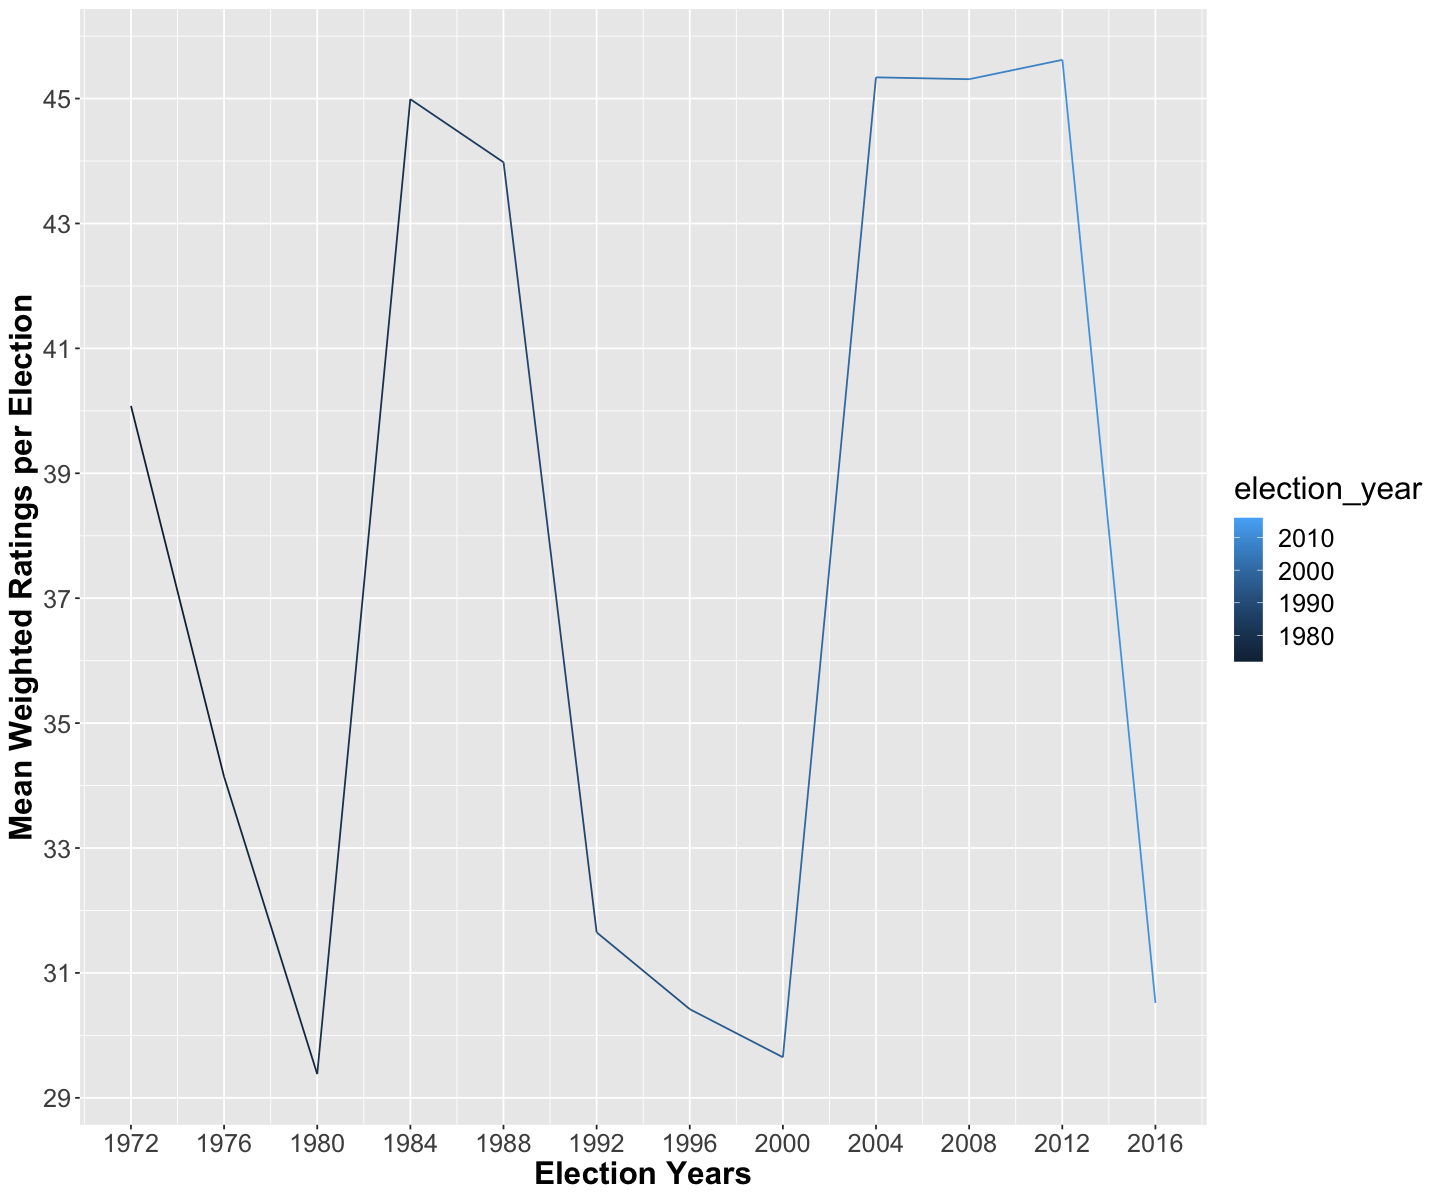

In [55]:
options(repr.plot.width = 12, repr.plot.height = 10)

line_graph <- ggplot(summary_stats) +
  geom_line(aes(x = election_year, y = mean_weighted_ratings, color = election_year)) +
  scale_x_continuous(breaks = seq(1972, 2016, 4)) +
  scale_y_continuous(breaks = seq(29, 46, 2)) +
  xlab("Election Years") +
  ylab("Mean Weighted Ratings per Election") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) 

line_graph